**Name: Kushal Wijesundara**
**UNI: kcw2144**


For this exercise we will try to predict the subjective quality of Portuguese red wine using only
the physiochemical properties of each wine. 
We will not use any the common regression methods and packages for Python or R - instead we will use minimization methods in order to minimize the error of a linear model. 
In this case, we will define error as Residual Sum of Squares (RSS), which is also often known as Squared Error.
Though the instructions below are specific to Python, the deliverable for this assignment can be either a Python or R notebook (markdown or pdf). 
Submit only this notebook (all code and question answers should be in this one file). This exercise should be relatively straight forward, so don’t overthink it, and keep it short and clear. Include the following steps.

## Setup
- Download and load the data set for red wine into a data frame
- http://archive.ics.uci.edu/ml/datasets/Wine+Quality
- Use only the red wine data, not the white wine data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import chisquare
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [3]:
df = pd.read_csv("./winequality-red.csv",sep=";")
df.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [4]:
# check for NA's and data types for pre-processing
df.info()
print("data shape: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
data shape:  (1599, 12)


- Split the data by columns into features that you will use for prediction, X, and the feature you will try to predict (‘quality’), y

In [5]:
X = df[df.columns[:-1]]
y = df[['quality']]

In [6]:
print("X data shape: ", X.shape)
print("y data shape: ", y.shape)

X data shape:  (1599, 11)
y data shape:  (1599, 1)


- Split both X and y by rows into training sets a testing sets
- Randomly split the data, keeping 80% of instances for training and 20% for testing
- At the end, you should have 4 data sets: X_train, y_train, X_test, and y_test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 123)

In [8]:
print("X_train data shape: ", X_train.shape)
print("X_test data shape: ", X_test.shape)
print("y_train data shape: ", y_train.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (1279, 11)
X_test data shape:  (320, 11)
y_train data shape:  (1279, 1)
y_test data shape:  (320, 1)


In [9]:
# Data to arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

## Regression equations and functions

- Write out two equations: 
- (1) the equation for the linear model that predicts y from X, and
- (2) the equation for computing the Residual Sum of Squares (RSS) for the linear model, given data, vector x, and parameters, vector β.
- See equations 3.1 and 3.2 in the Elements of Statistical Learning book
- Feel free to ignore the intercept term for this homework (e.g. β0)


- Equation (1) for a the linear model that predicts y from X
$$ y =   \beta_0 + \sum_{j=1}^{p} X_j \beta_j$$

- Equation (2) for computing the Residual Sum of Squares (RSS) for the linear model, given data, vector x, and parameters, vector β.
$$RSS(\beta) = \sum_{i=1}^{N}( y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j)$$

- When we ignore the intercept term β0, Equation (2) modifies to:
$$RSS(\beta) = \sum_{i=1}^{N}( y_i - \sum_{j=1}^{p} x_{ij} \beta_j)$$

- Translate these equations into code in the form of two functions
- The first function should compute the estimated value of y, which is y_hat, for particular values of x, and β. That is, there should be two arguments, one for the data and one for the linear function parameters.
- The second function should compute the RSS for the first function

In [10]:
#compute y_hat
def compute_yhat(beta, X):
    yhat = np.matmul(beta, X.T)
    return yhat.reshape(yhat.shape[0],1)

In [11]:
#compute RSS
def RSS(beta,X, y):
    y_hat = compute_yhat(X, beta)
    rss = np.sum((y-y_hat)**2)
    return rss

## Optimizing the model 

- Use Scipy’s minimize function to find the value of β that minimize the RSS
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- Your call to minimize method will take three arguments:
- (1) fun: the RSS function you defined above that you are trying to minimize
- (2) x0: your initial values of β
- (3) args: pass in all the data a tuple here. 
- For example:
- args=(y_train, X_train)
- For the second argument you will need to initialize β to some starting value. Try using a random vector with Numpy random methods
- numpy.random.normal(0, 1, X_train.shape[1])
- Your final set of functions to fit your model should have the form:
- def RSS(beta, X, y):
- return <some_results>
- res = minimize(fun=RSS, x0=beta0, args=(X_train,y_train))
- beta_hat = res.x

In [12]:
beta0 = np.random.normal(0, 1, X_train.shape[1])
res = minimize(fun=RSS, x0=beta0, args=(X_train,y_train))
beta_hat = res.x
print(beta_hat)

[-1.17134112e-02 -1.12665826e+00 -8.84374350e-02  4.73404242e-03
 -1.99505171e+00  2.19121001e-03 -3.27942432e-03  4.65174703e+00
 -4.64729386e-01  8.24084677e-01  2.86963534e-01]


### Questions:

- What are the qualitative results from your model? Which features seem to be most important? Do you think that the magnitude of the features in X may affect the results (for example, the average total sulfur dioxide across all wines is 46.47, but the average chlorides is only 0.087).


In [13]:
Results = { "Attribute" : list(X.columns.values), "Results" : res.x}
Results = pd.DataFrame(Results,columns=['Attribute','Results'])
Results

,Attribute,Results
0,fixed acidity,-0.011713
1,volatile acidity,-1.126658
2,citric acid,-0.088437
3,residual sugar,0.004734
4,chlorides,-1.995052
5,free sulfur dioxide,0.002191
6,total sulfur dioxide,-0.003279
7,density,4.651747
8,pH,-0.464729
9,sulphates,0.824085


In [14]:
sulfur = Results.loc[Results['Attribute'] == 'total sulfur dioxide']['Results'].iat[0]
chloride = Results.loc[Results['Attribute'] == 'chlorides']['Results'].iat[0]
average_sulfur = 46.47
average_chloride = 0.087
per_sulfur_change = average_sulfur*0.01*sulfur
per_chloride_change = average_chloride*0.01*chloride
print("Change in Quality for 1 percent change in total sulfur dioxide = " + str(per_sulfur_change))
print("Change in Quality for 1 percent change in chlorides = " + str(per_chloride_change))

Change in Quality for 1 percent change in total sulfur dioxide = -0.0015239484816727616
Change in Quality for 1 percent change in chlorides = -0.0017356949844758007


### Answer

- It seems that the 'density' is the most important feature as well as features like 'chlorides' and 'volatile acidity' as they have the highest absolute value for the beta, based on the coefficients beta for each variable. But the magnitudes of the features are quite different. But the results of the above analysis (table results above) give only the regression coefficients. The variables are not based on the same scale and hence these regression value are uncomparable. To Compare the regression values, we need to standardise the variables or use normalisation to bring them to the same scale. Form the comparison results for sulfer and chloride, we see that although the value for chlorides was much higher than that of the total sulfur dioxide, we can see, the percent changes for both the attributes are quite similar. 

### Question

- How well does your model fit? You should be able to measure the goodness of fit, RSS, on both the training data and the test data, but only report the results on the test data. In Machine Learning we almost always only care about how well the model fits on data that has not been used to fit the model, because we need to use the model in the future, not the past. Therefore, we only report performance with holdout data, or test data.


In [15]:
# compute RSS for both training and test from optimized values beta_hat
RSS_train = RSS(beta_hat, X_train, y_train)
print ("RSS for training data {0:.2f}".format(RSS_train))
RSS_test = RSS(beta_hat, X_test, y_test)
print ("RSS for test data {0:.2f}".format(RSS_test))

RSS for training data 529.28
RSS for test data 139.61


- The RSS on the test data is 139.61. Since the RSS is a function of number of data points in the within the dataset, it can  be used for comparison across different methods

### Question

- Does the end result or RSS change if you try different initial values of β? What happens if you change the magnitude of the initial β?

In [16]:
def RSS_minimize(beta0, X_test, y_test, solver='Powell'):
    res = minimize(fun=RSS, x0=beta0, method=solver, args=(X_train,y_train))
    beta_hat = res.x
    return RSS(beta_hat, X_test, y_test)

In [17]:
RSS_1 = RSS_minimize(beta0=[1,20,-3,24,-95,1116,-7000,88,91,190,-311], X_test=X_test, y_test=y_test)
RSS_2 = RSS_minimize(beta0=list(range(10000,10011)), X_test=X_test, y_test=y_test)
RSS_3 = RSS_minimize(beta0=list(range(-20,-31,-1)), X_test=X_test, y_test=y_test)
RSS_4 = RSS_minimize(beta0=list(range(-20000,-20011,-1)), X_test=X_test, y_test=y_test)

In [18]:
print('RSS for different starting points {0:.2f}, {0:.2f}, {0:.2f}, {0:.2f}'.format(RSS_1, RSS_2, RSS_3, RSS_4))

RSS for different starting points 139.61, 139.61, 139.61, 139.61


### Answer

- With change in the initial value of $\beta$,  RSS doesn't seems to change. Also by changing the magnitude of the initial  $\beta$ did not change the results of the RSS values.

### Question

- Does the choice of solver method change the end result or RSS?

In [19]:
def RSS_Solver(beta, X_train, y_train, X_test, y_test, solver) :
    res = minimize(fun=RSS, x0=beta, method=solver, args=(X_train,y_train))
    beta_hat = res.x
    test_RSS = RSS(beta_hat,X_test,y_test)
    return test_RSS

In [20]:
solver = ['CG','BFGS','L-BFGS-B','SLSQP','TNC','Nelder-Mead','Powell','COBYLA']

In [21]:
for i in range(len(solver)):
    rss_test = RSS_Solver(beta0, X_train, y_train, X_test, y_test, solver[i])
    print ("RSS:" , round(rss_test,2), "; Solver:", solver[i])

RSS: 139.63 ; Solver: CG
RSS: 139.61 ; Solver: BFGS
RSS: 139.55 ; Solver: L-BFGS-B
RSS: 139.61 ; Solver: SLSQP
RSS: 145.63 ; Solver: TNC
RSS: 239.36 ; Solver: Nelder-Mead
RSS: 139.6 ; Solver: Powell
RSS: 398.03 ; Solver: COBYLA


### Answer

- The Choice of the solver method does affect the RSS value since  different solvers have different assumptions and this affects the way optimize the problem (local optimizations) since they are not finding analytical closed-form solution. Here we observed CG and BFGS gives lowest RSS values and COBYLA gives largest RSS value.

## Regularizing the model 

Regularization seeks to simplify a model by decreasing the model’s complexity and degrees of
freedom. While lowering the degrees of freedom also decreases the flexibility of the model, and
therefore the performance of the model on training data, it increases generalizability, and thus it
often increases performance on test data. One common method of regularization is called
shrinkage, and is defined in section 3.4 of Elements of Statistical Learning.

 - Try adding in an L2 (aka Ridge) regularization penalty to your model above to create a new, regularized model. 
 - See equation 3.41 for guidance. You will need to choose a value of lambda, so start with something small, like 0.01.

In [22]:
# New Regularization model for RSS 

def RSS_reg(beta, X, y, l_reg, reg = 'l2'):
    yhat = compute_yhat(beta, X)    
      
    if reg == 'l2':
        return (np.sum((y-yhat)**2)+
                (l_reg*np.sum(beta**2)))
    elif reg == 'l1':
        return (np.sum((y-yhat)**2)+
                (l_reg*np.sum(np.abs(beta))))

In [23]:
def RSS_min(beta0, X_test, y_test, l_reg=0.01, reg='l2'):
    reg_res = minimize(fun=RSS_reg, x0=beta0, args=(X_train, y_train, l_reg, reg))
    reg_beta_hat = reg_res.x
    return RSS(reg_beta_hat, X_test, y_test)

### Questions

- How does RSS on the training data change? How does RSS on the test data change?
- What happens if you try different values of lambda? 
- Can you tune lambda to get the best results on the test data?

### Answers

In [24]:
# RSS for both training and test from Regularized Model L2 with lambda 0.01
RSS_Train_Reg_L2 = RSS_min(beta0, X_train, y_train, l_reg=0.01, reg='l2')
RSS_Test_Reg_L2 = RSS_min(beta0, X_test, y_test, l_reg=0.01, reg='l2')
print ("RSS for train data from Regularized Model: L2 ", round(RSS_Train_Reg_L2,4))
print ("RSS for test data from Regularized Model: L2  ", round(RSS_Test_Reg_L2,4))

# RSS for both training and test from optimized values beta_hat
RSS_train = RSS(beta_hat, X_train, y_train)
print ("RSS for train data from optimized values beta_hat {0:.4f}".format(RSS_train))
RSS_test = RSS(beta_hat, X_test, y_test)
print ("RSS for test data from optimized values beta_hat {0:.4f}".format(RSS_test))

RSS for train data from Regularized Model: L2  529.281
RSS for test data from Regularized Model: L2   139.5924
RSS for train data from optimized values beta_hat 529.2779
RSS for test data from optimized values beta_hat 139.6091


 - From Regularized Model L2 with lambda 0.01:
 - RSS on the train data increased marginally by 0.0031 (i.e., 529.2779 to 529.281) 
 - RSS on the test data decreased marginally by 0.0167 (i.e., 139.6091 to 139.5924) 

C:\Users\IBM\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


RSS from traindata and lambda values:
0.0001: 529.277858
0.0002: 529.277859
0.0003: 529.27786
0.0004: 529.277863
0.0006: 529.277869
0.0008: 529.277878
0.001: 529.27789
0.002: 529.277985
0.003: 529.278142
0.004: 529.278362
0.006: 529.278986
0.008: 529.279851
0.01: 529.280956
0.02: 529.289941
0.03: 529.304382
0.04: 529.323886
0.06: 529.37663
0.08: 529.445525
0.1: 529.528297
0.2: 530.088977
0.3: 530.786428
0.4: 531.532481
0.6: 533.011197
0.8: 534.371359
1: 535.584079
2: 539.89862
3: 542.549861
4: 544.437276
6: 547.19244
8: 549.341296
10: 551.212677
20: 558.950507
30: 565.322775
40: 570.747402
60: 579.43555
80: 586.032167
100: 591.188286
200: 606.076456
300: 613.49955
400: 618.300999
600: 624.987511
800: 630.262876
1000: 635.07949


Text(0.5, 1.0, 'RSS vs L2 Regularization(Ridge) Train set')

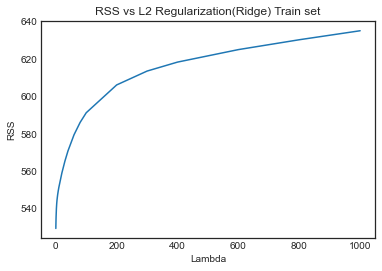

In [25]:
#  L2 Regularization - Train data
lamda = [0.0001,0.0002,0.0003,0.0004,0.0006,0.0008,0.001,0.002,0.003,0.004,
         0.006,0.008,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.2,0.3,0.4,
         0.6,0.8,1,2,3,4,6,8,10,20,30,40,60,80,100,200,300,400,600,800,1000]
RSStrainl2 = OrderedDict()
for l in (lamda):
    RSStrainl2[l] = RSS_min(beta0, X_train, y_train, l, reg='l2')
RSStrainL2= [str(i)+": "+str(round(RSStrainl2[i],6)) for i in RSStrainl2]
print ('RSS from traindata and lambda values:')
for i in RSStrainL2:
    print (i)
plt.plot(*zip(*sorted(RSStrainl2.items())))
#plt.xscale('log')
#plt.xlabel('log(Lambda)')
plt.xlabel('Lambda')
plt.ylabel('RSS')
plt.title('RSS vs L2 Regularization(Ridge) Train set')


C:\Users\IBM\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


RSS from traindata and lambda values:
0.0001: 139.608949
0.0002: 139.608774
0.0003: 139.608597
0.0004: 139.608421
0.0006: 139.608073
0.0008: 139.607723
0.001: 139.607377
0.002: 139.605649
0.003: 139.603938
0.004: 139.602246
0.006: 139.598911
0.008: 139.595647
0.01: 139.59245
0.02: 139.57746
0.03: 139.564046
0.04: 139.552108
0.06: 139.532292
0.08: 139.517328
0.1: 139.506641
0.2: 139.501335
0.3: 139.547221
0.4: 139.619787
0.6: 139.796534
0.8: 139.979173
1: 140.151026
2: 140.790697
3: 141.183207
4: 141.453468
6: 141.828061
8: 142.105471
10: 142.340986
20: 143.31655
30: 144.154371
40: 144.89078
60: 146.094417
80: 147.008356
100: 147.708529
200: 149.511832
300: 150.137362
400: 150.371282
600: 150.482001
800: 150.513614
1000: 150.603315


Text(0.5, 1.0, 'RSS vs L2 Regularization(Ridge) Test set')

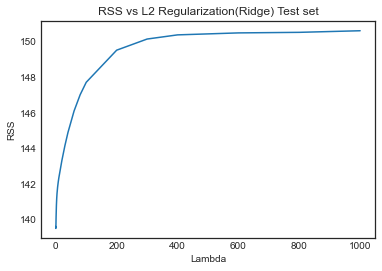

In [26]:
#  L2 Regularization - Test data
lamda = [0.0001,0.0002,0.0003,0.0004,0.0006,0.0008,0.001,0.002,0.003,0.004,
         0.006,0.008,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.2,0.3,0.4,
         0.6,0.8,1,2,3,4,6,8,10,20,30,40,60,80,100,200,300,400,600,800,1000]
RSStestl2 = OrderedDict()
for l in (lamda):
    RSStestl2[l] = RSS_min(beta0, X_test, y_test, l, reg='l2')
RSStestL2= [str(i)+": "+str(round(RSStestl2[i],6)) for i in RSStestl2]
print ('RSS from traindata and lambda values:')
for i in RSStestL2:
    print (i)
plt.plot(*zip(*sorted(RSStestl2.items())))
#plt.xscale('log')
#plt.xlabel('log(Lambda)')
plt.xlabel('Lambda')
plt.ylabel('RSS')
plt.title('RSS vs L2 Regularization(Ridge) Test set')


- As shown in the above two plot  by tunning lambda we obtained RSS vs L2 Regularization(Ridge) Train and Test set and obtained quite smoooth plots. Typically RSS increase with increasing lambda for both Train and Test sets. For the Train set, first lambda slightly decreases and then continues to increase indicating that there is an optimum point at lambda equal to 0.001.For the Test set, first lambda slightly decreases and then continues to increase indicating that there is an optimum point at lambda equal to 0.2

### Questions

- Now try using an L1 (aka Lasso) regularization penalty instead. 
- See equation 3.51 for example. 
- Report your findings on how RSS changes, and if you can roughly tune lambda.

### Answers

In [27]:
# RSS for both training and test from Regularized Model L1 with lambda 0.01
RSS_Train_Reg_L1 = RSS_min(beta0, X_train, y_train, l_reg=0.01, reg='l1')
RSS_Test_Reg_L1 = RSS_min(beta0, X_test, y_test, l_reg=0.01, reg='l1')
print ("RSS for train data from Regularized Model: L1 ", round(RSS_Train_Reg_L2,4))
print ("RSS for test data from Regularized Model: L1  ", round(RSS_Test_Reg_L2,4))

# RSS for both training and test from optimized values beta_hat
RSS_train = RSS(beta_hat, X_train, y_train)
print ("RSS for train data from optimized values beta_hat {0:.4f}".format(RSS_train))
RSS_test = RSS(beta_hat, X_test, y_test)
print ("RSS for test data from optimized values beta_hat {0:.4f}".format(RSS_test))

RSS for train data from Regularized Model: L1  529.281
RSS for test data from Regularized Model: L1   139.5924
RSS for train data from optimized values beta_hat 529.2779
RSS for test data from optimized values beta_hat 139.6091


 - From Regularized Model L1 with lambda 0.01:
 - RSS on the train data increased marginally by 0.0031 (i.e., 529.2779 to 529.281) 
 - RSS on the test data decreased marginally by 0.0167 (i.e., 139.6091 to 139.5924)

RSS from traindata and lambda values:
0.0001: 529.277857
0.0002: 529.277857
0.0003: 529.277857
0.0004: 529.277857
0.0006: 529.277858
0.0008: 529.277858
0.001: 529.277858
0.002: 529.27786
0.003: 529.277864
0.004: 529.277869
0.006: 529.277883
0.008: 529.277903
0.01: 529.277929
0.02: 529.278143
0.03: 529.278498
0.04: 529.278995
0.06: 529.280415
0.08: 529.282401
0.1: 529.284956
0.2: 529.306235
0.3: 529.341693
0.4: 529.391335
0.6: 529.533169
0.8: 529.731725
1: 529.962133
2: 532.014843
3: 534.006697
4: 535.504435
6: 542.925409
8: 547.980553
10: 548.801933
20: 559.127594
30: 570.48574
40: 594.348342
60: 607.247829
80: 622.168501
100: 634.538773
200: 639.344248
300: 639.730116


Text(0.5, 1.0, 'RSS vs L1 Regularization(Lasso) Train set')

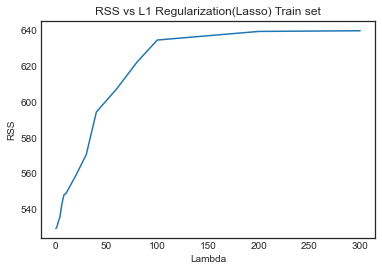

In [28]:
# L1 Regularization - Train data
lamda = [0.0001,0.0002,0.0003,0.0004,0.0006,0.0008,0.001,0.002,0.003,0.004,
         0.006,0.008,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.2,0.3,0.4,
         0.6,0.8,1,2,3,4,6,8,10,20,30,40,60,80,100,200,300]
RSStrainl1 = OrderedDict()
for l in (lamda):
    RSStrainl1[l] = RSS_min(beta0, X_train, y_train, l, reg='l1')
RSStrainL1 = [str(i)+": "+str(round(RSStrainl1[i],6)) for i in RSStrainl1]
print ('RSS from traindata and lambda values:')
for i in RSStrainL1:
    print (i)
plt.plot(*zip(*sorted(RSStrainl1.items())))
#plt.xscale('log')
#plt.xlabel('log(Lambda)')
plt.xlabel('Lambda')
plt.ylabel('RSS')
plt.title('RSS vs L1 Regularization(Lasso) Train set')

RSS from testdata and lambda values:
0.0001: 139.609119
0.0002: 139.609112
0.0003: 139.609113
0.0004: 139.609112
0.0006: 139.609105
0.0008: 139.6091
0.001: 139.609094
0.002: 139.609067
0.003: 139.609038
0.004: 139.609009
0.006: 139.608955
0.008: 139.608901
0.01: 139.60885
0.02: 139.608604
0.03: 139.608389
0.04: 139.608198
0.06: 139.607923
0.08: 139.607756
0.1: 139.607708
0.2: 139.609243
0.3: 139.613719
0.4: 139.621145
0.6: 139.64483
0.8: 139.680301
1: 139.762655
2: 140.199959
3: 140.448529
4: 140.321164
6: 141.54292
8: 141.875301
10: 142.035591
20: 142.828099
30: 143.190652
40: 145.872611
60: 151.039513
80: 153.987346
100: 154.576207
200: 156.040959
300: 155.493051


Text(0.5, 1.0, 'RSS vs L1 Regularization(Lasso) Test set')

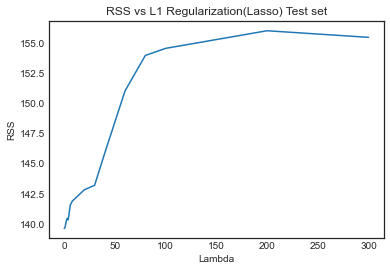

In [29]:
# L1 Regularization - Test data

lamda = [0.0001,0.0002,0.0003,0.0004,0.0006,0.0008,0.001,0.002,0.003,0.004,
         0.006,0.008,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.2,0.3,0.4,
         0.6,0.8,1,2,3,4,6,8,10,20,30,40,60,80,100,200,300]
RSStestl1 = OrderedDict()
for l in (lamda):
    RSStestl1[l] = RSS_min(beta0, X_test, y_test, l, reg='l1')
RSStestL1 = [str(i)+": "+str(round(RSStestl1[i],6)) for i in RSStestl1]
print ('RSS from testdata and lambda values:')
for i in RSStestL1:
    print (i)
plt.plot(*zip(*sorted(RSStestl1.items())))
#plt.xscale('log')
#plt.xlabel('log(Lambda)')
plt.xlabel('Lambda')
plt.ylabel('RSS')
plt.title('RSS vs L1 Regularization(Lasso) Test set')

- As shown in the above two plot  by tunning lambda we obtained RSS vs L1 Regularization(Lasso) Train and Test set plots. Typically RSS increase with increasing lambda for both Train and Test sets. However, for the Test set, first lambda slightly decreases and then continues to increase indicating that there is an optimum point at lambda equal to 0.1. For the train set best lambda would be around 0.0001

### Question

- Again, do you think that the magnitude of the features in X may affect the results with regularization?

### Answer

- Typically with regularization beta coefficients are reduced, but the magnitube of the features do effect the coefficients because it penalizes the large values of cooefficients to keep the overall function to minimum. Therefore, regularization would normally reduce the less prominent features; thus I do not think that the magnitude of X's features will necessarily affect the results with regularization.